# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm_notebook as tqdm

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))

from visualization.plots_v2 import scrollable_loss_vs_hist, initial_vs_final_overlap, MSD_plot

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [2]:
from pathlib import Path
import re

# Frozen Features

## MSD Plots

Text(0.5, 1.0, 'MSD throughout training')

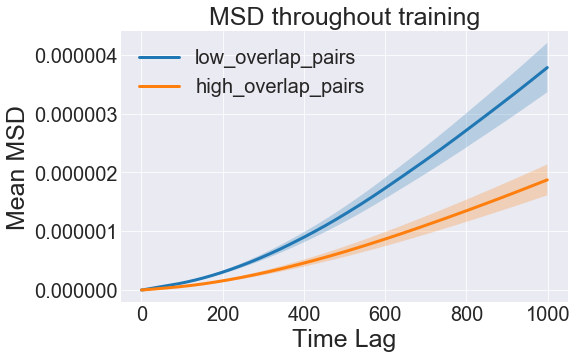

In [3]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0
max_time_lag = 1000

MSD_plot(parent_dir, run_num, max_time_lag)
plt.title('MSD throughout training', fontsize=25)

/home/manu/Projects/dev/weightSymmetry/visualization/plots_v2.py:90: RuntimeWarning: Mean of empty slice.
  sq_diff = ((cd_ranked[i:] - cd_ranked[:-i])**2).mean(axis=0)
/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0.5, 1.0, 'MSD first 100 batches')

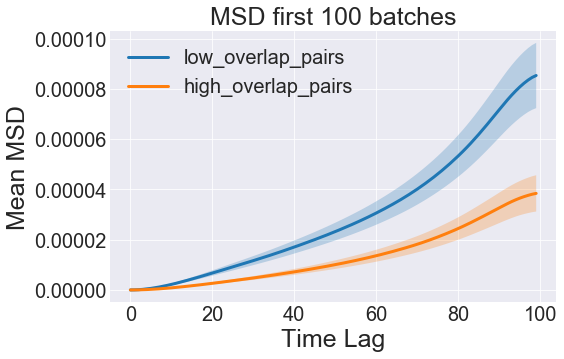

In [4]:
MSD_plot(parent_dir, run_num, max_time_lag, start_batch=0, end_batch=100)
plt.title('MSD first 100 batches', fontsize=25)

Text(0.5, 1.0, 'MSD 100-1000 batches')

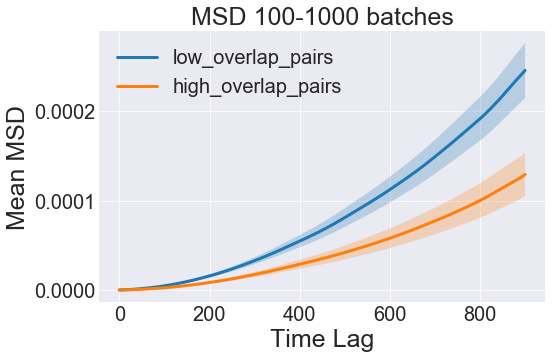

In [5]:
MSD_plot(parent_dir, run_num, max_time_lag, start_batch=100, end_batch=1000)
plt.title('MSD 100-1000 batches', fontsize=25)

Text(0.5, 1.0, 'MSD 1000-10000 batches')

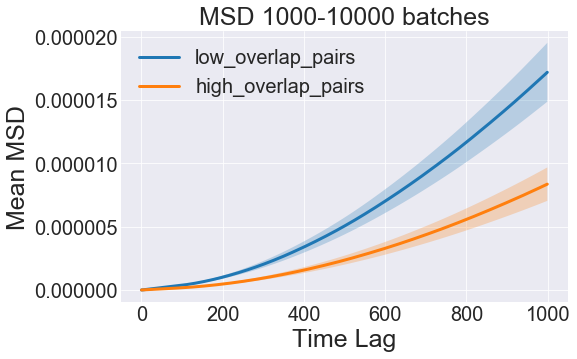

In [6]:
MSD_plot(parent_dir, run_num, max_time_lag, start_batch=1000, end_batch=10000)
plt.title('MSD 1000-10000 batches', fontsize=25)

Text(0.5, 1.0, 'MSD 10000-20000 batches')

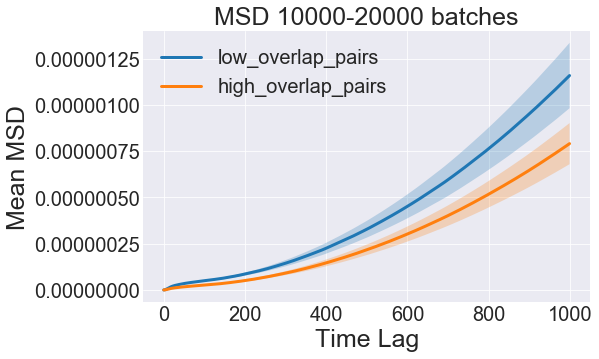

In [7]:
MSD_plot(parent_dir, run_num, max_time_lag, start_batch=10000, end_batch=20000)
plt.title('MSD 10000-20000 batches', fontsize=25)

Text(0.5, 1.0, 'MSD 20000 batches onward')

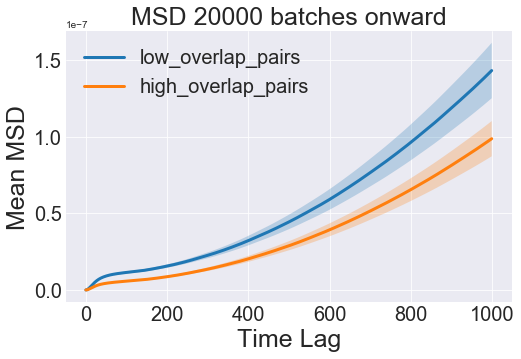

In [8]:
MSD_plot(parent_dir, run_num, max_time_lag, start_batch=20000)
plt.title('MSD 20000 batches onward', fontsize=25)

Text(0.5, 1.0, 'MSD 20000 batches onward')

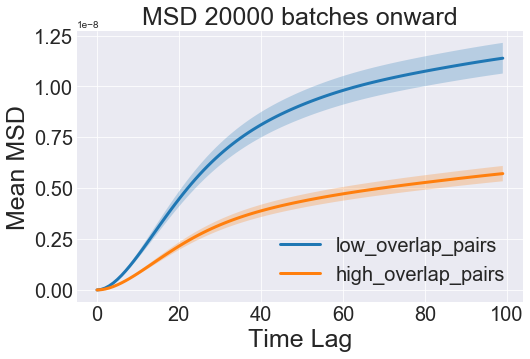

In [9]:
max_time_lag = 100

MSD_plot(parent_dir, run_num, max_time_lag, start_batch=20000)
plt.title('MSD 20000 batches onward', fontsize=25)

## Overlap at different stages

### 1 epoch = 117 batches

In [10]:
from utils.utils import pairwise_cos_dist

In [11]:
def init_vs_final_overlap(parent_dir, run_num, epoch_num):
    
    net = torch.load(os.path.join(parent_dir, 'weight_history', 'run_' + str(run_num), 'epoch_' + str(epoch_num) + '.pt'))
    net_init = torch.load(os.path.join(parent_dir, 'weight_history', 'run_' + str(run_num), 'epoch_1.pt'))
    
    cos_dist_init = pairwise_cos_dist(net_init.dense_2)
    cos_dist = pairwise_cos_dist(net.dense_2)
    
    num_neurons = cos_dist.shape[1]
    iu2 = np.triu_indices(num_neurons, k=1)
    
    plt.scatter(cos_dist_init[iu2], cos_dist[iu2])

Text(0, 0.5, 'Final overlap')

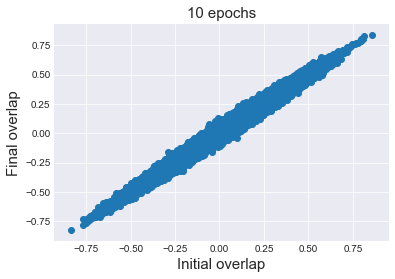

In [12]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0

init_vs_final_overlap(parent_dir, run_num, 10)
plt.title('10 epochs', fontsize=15)
plt.xlabel('Initial overlap', fontsize=15)
plt.ylabel('Final overlap', fontsize=15)

Text(0, 0.5, 'Final overlap')

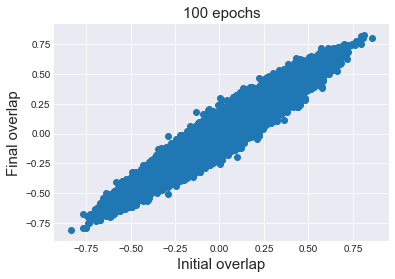

In [13]:
init_vs_final_overlap(parent_dir, run_num, 100)
plt.title('100 epochs', fontsize=15)
plt.xlabel('Initial overlap', fontsize=15)
plt.ylabel('Final overlap', fontsize=15)

Text(0, 0.5, 'Final overlap')

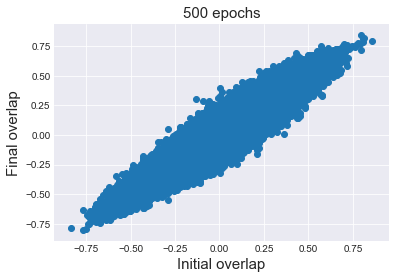

In [14]:
init_vs_final_overlap(parent_dir, run_num, 500)
plt.title('500 epochs', fontsize=15)
plt.xlabel('Initial overlap', fontsize=15)
plt.ylabel('Final overlap', fontsize=15)

Text(0, 0.5, 'Final overlap')

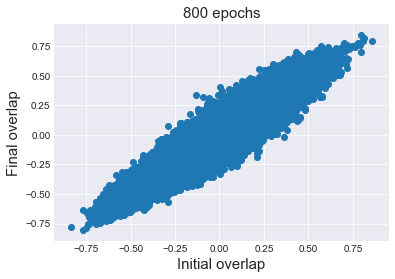

In [15]:
init_vs_final_overlap(parent_dir, run_num, 800)
plt.title('800 epochs', fontsize=15)
plt.xlabel('Initial overlap', fontsize=15)
plt.ylabel('Final overlap', fontsize=15)

## Histograms

In [16]:
%matplotlib qt

In [17]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0
ylim = 200
steps = 20

scrollable_loss_vs_hist(parent_dir, run_num, steps=steps, net2net=False)

# Diff vs Mean Plots

In [18]:
%matplotlib inline

In [3]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0

cd_ranked = np.clip(np.load(os.path.join(parent_dir, 'cosine_dists_diff_' + str(run_num) + '.npy')), -1, 1)
sd_ranked = np.sqrt(1-cd_ranked**2)
cm_ranked = np.clip(np.load(os.path.join(parent_dir, 'cosine_dists_mean_' + str(run_num) + '.npy')), -1, 1)
sm_ranked = np.sqrt(1-cm_ranked**2)
loss_curve = np.load(os.path.join(parent_dir, 'loss_curve_' + str(run_num) + '.npy'))

cd_flow = cd_ranked[1:] - cd_ranked[:-1]
cm_flow = cm_ranked[1:] - cm_ranked[:-1]

sd_flow = sd_ranked[1:] - sd_ranked[:-1]
sm_flow = sm_ranked[1:] - sm_ranked[:-1]

In [4]:
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
for i in range(10):
    x = nn.Linear(20, 500)
    
    w = x.weight.data.cpu()
    b = x.bias.data.cpu()
    w1 = torch.cat((w,b.unsqueeze(1)), dim=1)

    cd = cosine_similarity(w,w)
    print(np.min(cd))

-0.82835716
-0.8516621
-0.8452994
-0.81393117
-0.782873
-0.8184487
-0.7920479
-0.8094109
-0.8491751
-0.81527936


In [32]:
for i in range(10):
    x = nn.Linear(20, 500)
    
    w = x.weight.data.cpu()
    b = x.bias.data.cpu()
    w1 = torch.cat((w,b.unsqueeze(1)), dim=1)

    cd = cosine_similarity(w,w)
    print(np.max(cd))

1.0000002
1.0000004
1.0000002
1.0000004
1.0000004
1.0000004
1.0000004
1.0000002
1.0000004
1.0000002


In [29]:
for i in range(10):
    x = np.random.random((20, 500))

    cd = cosine_similarity(x,x)
    print(np.max(cd))

1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0000000000000009
1.0000000000000007
1.0000000000000009
1.0000000000000004


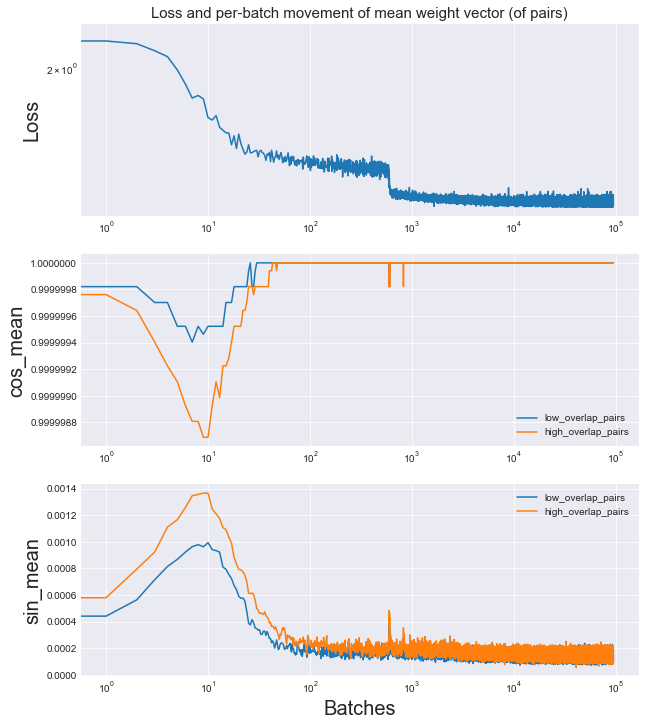

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax1.set_title('Loss and per-batch movement of mean weight vector (of pairs)', fontsize=15)
ax1.loglog(loss_curve)
ax1.set_ylabel('Loss', fontsize=20)
ax2 = fig.add_subplot(312)
ax2.semilogx(np.mean(cm_ranked[:,:100], axis=1), label='low_overlap_pairs')
ax2.semilogx(np.mean(cm_ranked[:,100:], axis=1), label='high_overlap_pairs')
ax2.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.set_ylabel('cos_mean', fontsize=20)
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.semilogx(np.mean(sm_ranked[:,:100], axis=1), label='low_overlap_pairs')
ax3.semilogx(np.mean(sm_ranked[:,100:], axis=1), label='high_overlap_pairs')
ax3.set_ylabel('sin_mean', fontsize=20)
ax3.set_xlabel('Batches', fontsize=20)
ax3.legend()

The mean weight vector moves very very little every update (which is why we see values close to 1 in the graph above). Slightly larger movements over longer time steps (log intervals), higher learning rates and smaller batches, but not by much.

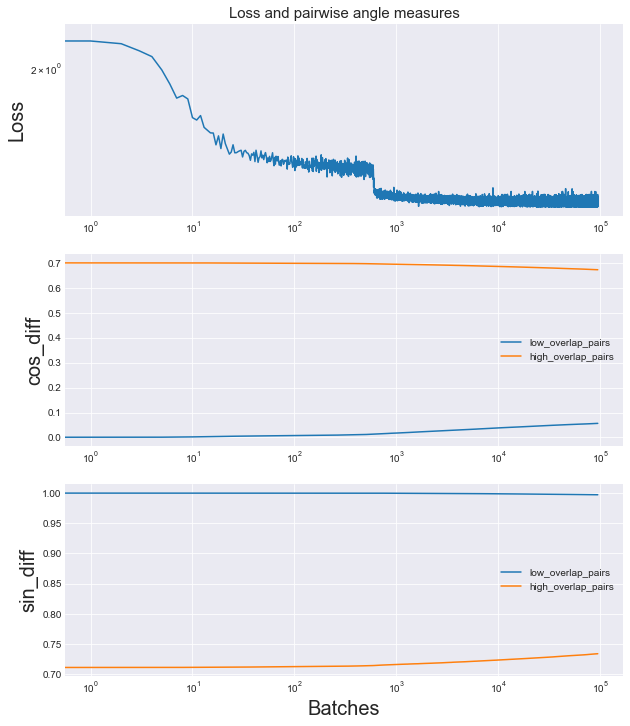

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax1.set_title('Loss and pairwise angle measures', fontsize=15)
ax1.loglog(loss_curve)
ax1.set_ylabel('Loss', fontsize=20)
ax2 = fig.add_subplot(312)
ax2.semilogx(np.mean(np.abs(cd_ranked[:,:100]), axis=1), label='low_overlap_pairs')
ax2.semilogx(np.mean(np.abs(cd_ranked[:,100:]), axis=1), label='high_overlap_pairs')
ax2.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.set_ylabel('cos_diff', fontsize=20)
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.semilogx(np.mean(sd_ranked[:,:100], axis=1), label='low_overlap_pairs')
ax3.semilogx(np.mean(sd_ranked[:,100:], axis=1), label='high_overlap_pairs')
ax3.set_ylabel('sin_diff', fontsize=20)
ax3.set_xlabel('Batches', fontsize=20)
ax3.legend()

## Individual Pairs

Text(0.04, 0.5, 'cos_mean')

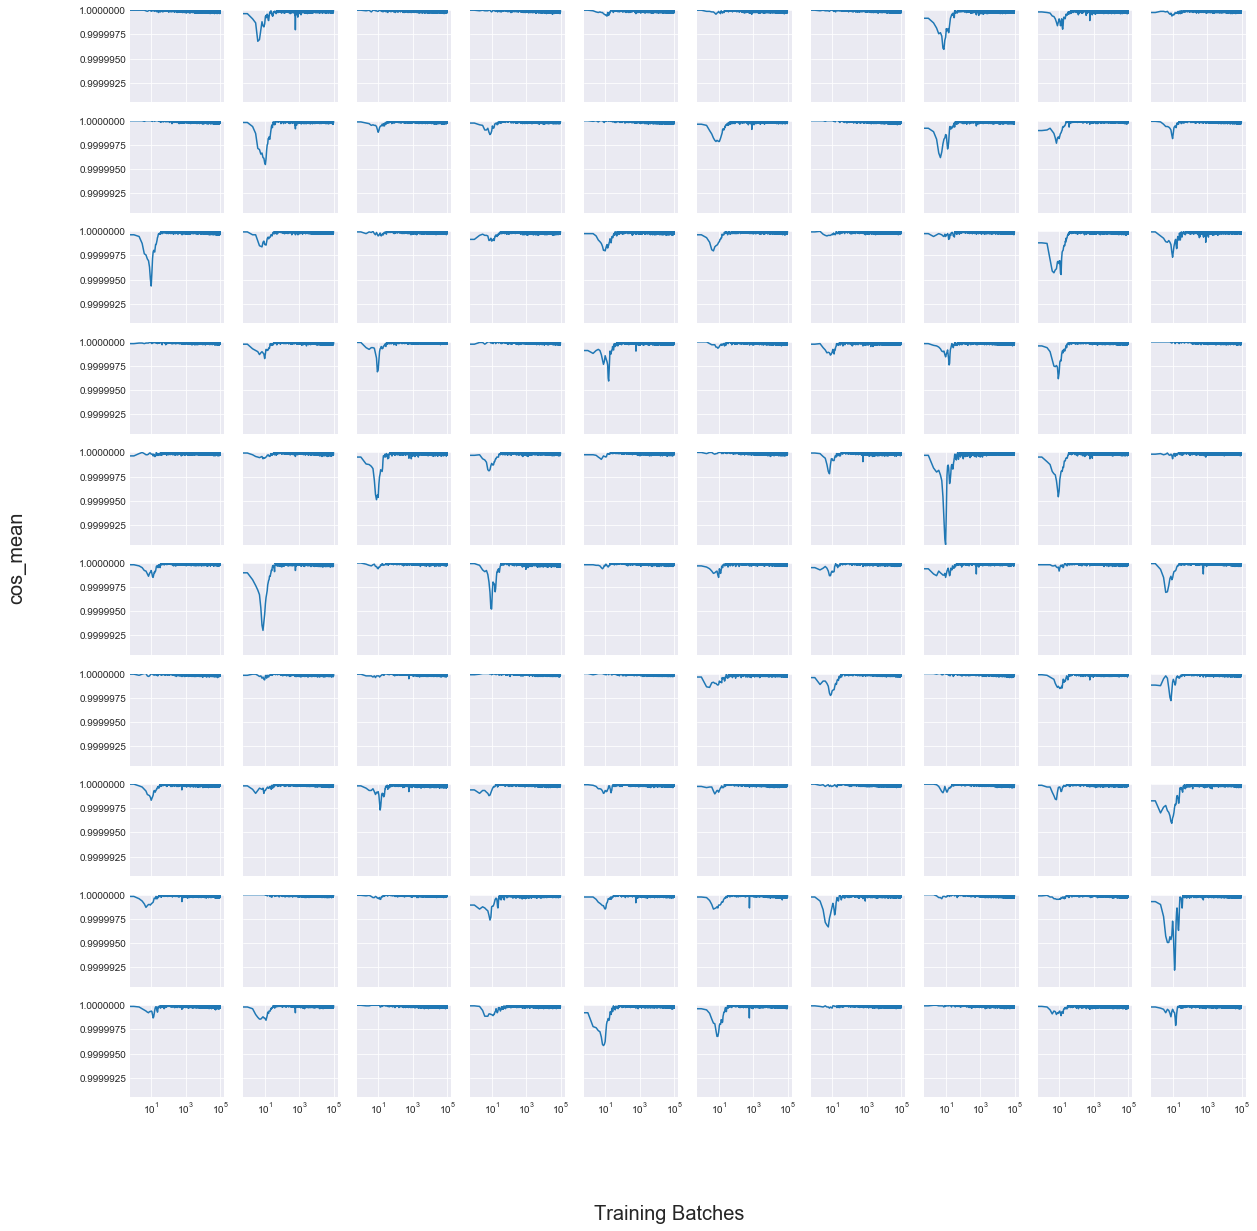

In [ ]:
fig, ax = plt.subplots(10,10, figsize=(20,20))
i=0
for row in ax:
    for col in row:
        col.semilogx(cm_ranked[:,100+i])
        col.set_ylim(cm_ranked[:,100:].min(), 1)
        col.get_yaxis().get_major_formatter().set_useOffset(False)
        if i%10 != 0:
            col.set_yticklabels([])
        if i<90:
            col.set_xticklabels([])
        i += 1
fig.text(0.5, 0.04, 'Training Batches', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'cos_mean', va='center', rotation='vertical', fontsize=20)

Text(0.04, 0.5, 'sin_mean')

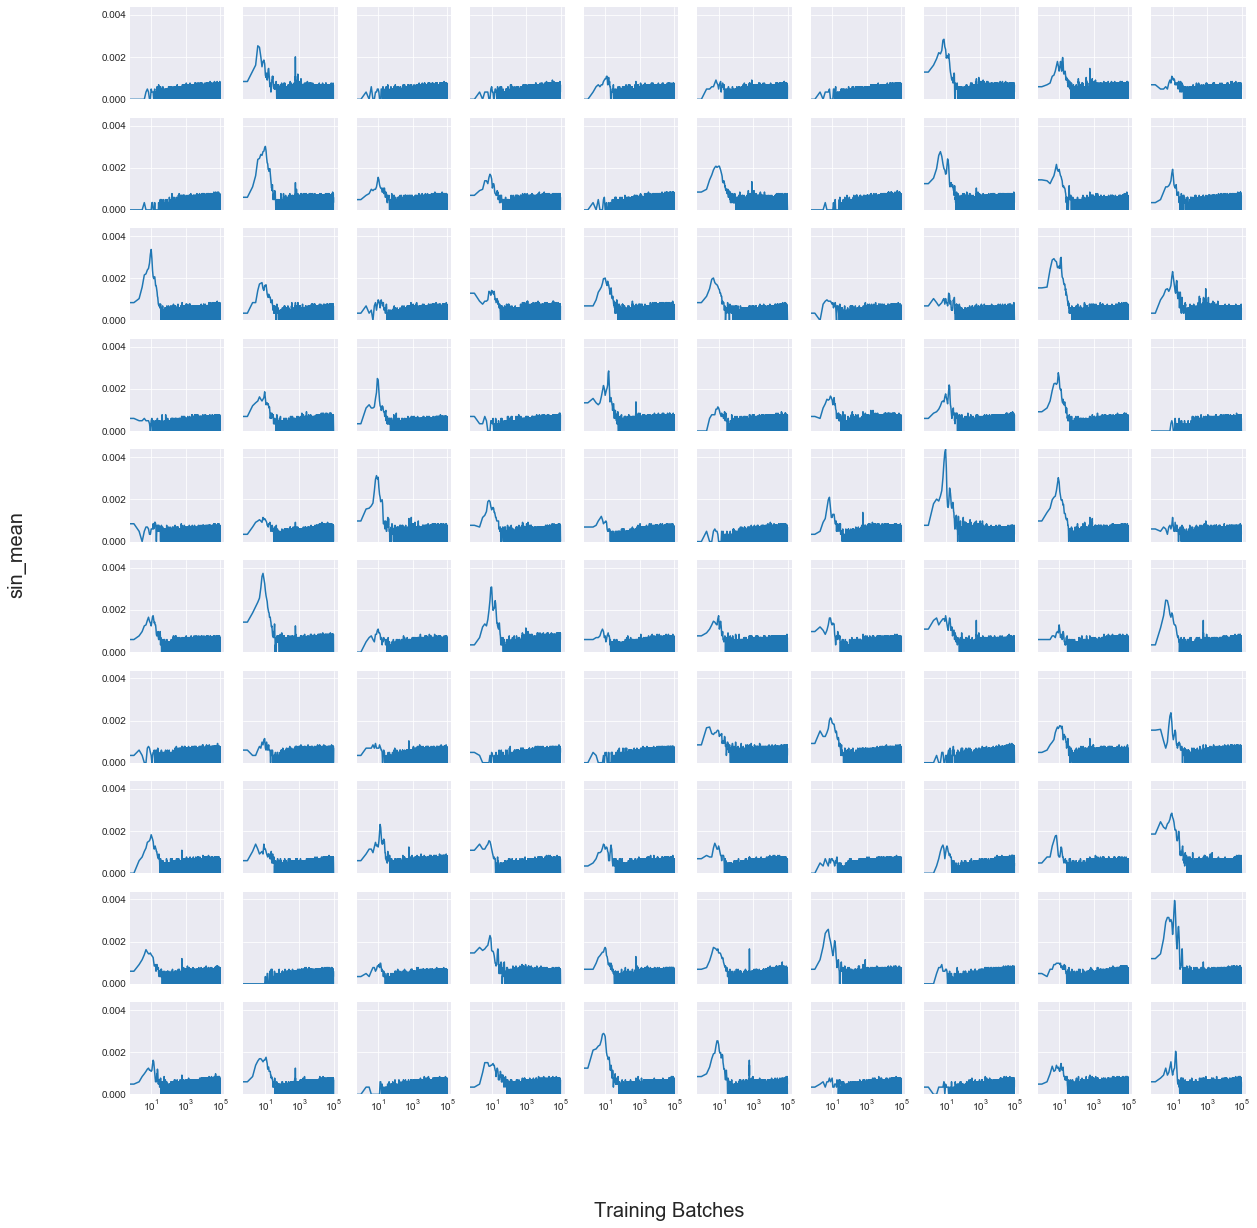

In [ ]:
fig, ax = plt.subplots(10,10, figsize=(20,20))
i=0
for row in ax:
    for col in row:
        col.semilogx(sm_ranked[:,100+i])
        col.set_ylim(0, sm_ranked[:,100:].max())
        col.get_yaxis().get_major_formatter().set_useOffset(False)
        if i%10 != 0:
            col.set_yticklabels([])
        if i<90:
            col.set_xticklabels([])
        i += 1
fig.text(0.5, 0.04, 'Training Batches', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'sin_mean', va='center', rotation='vertical', fontsize=20)

Text(0.04, 0.5, 'cos_mean')

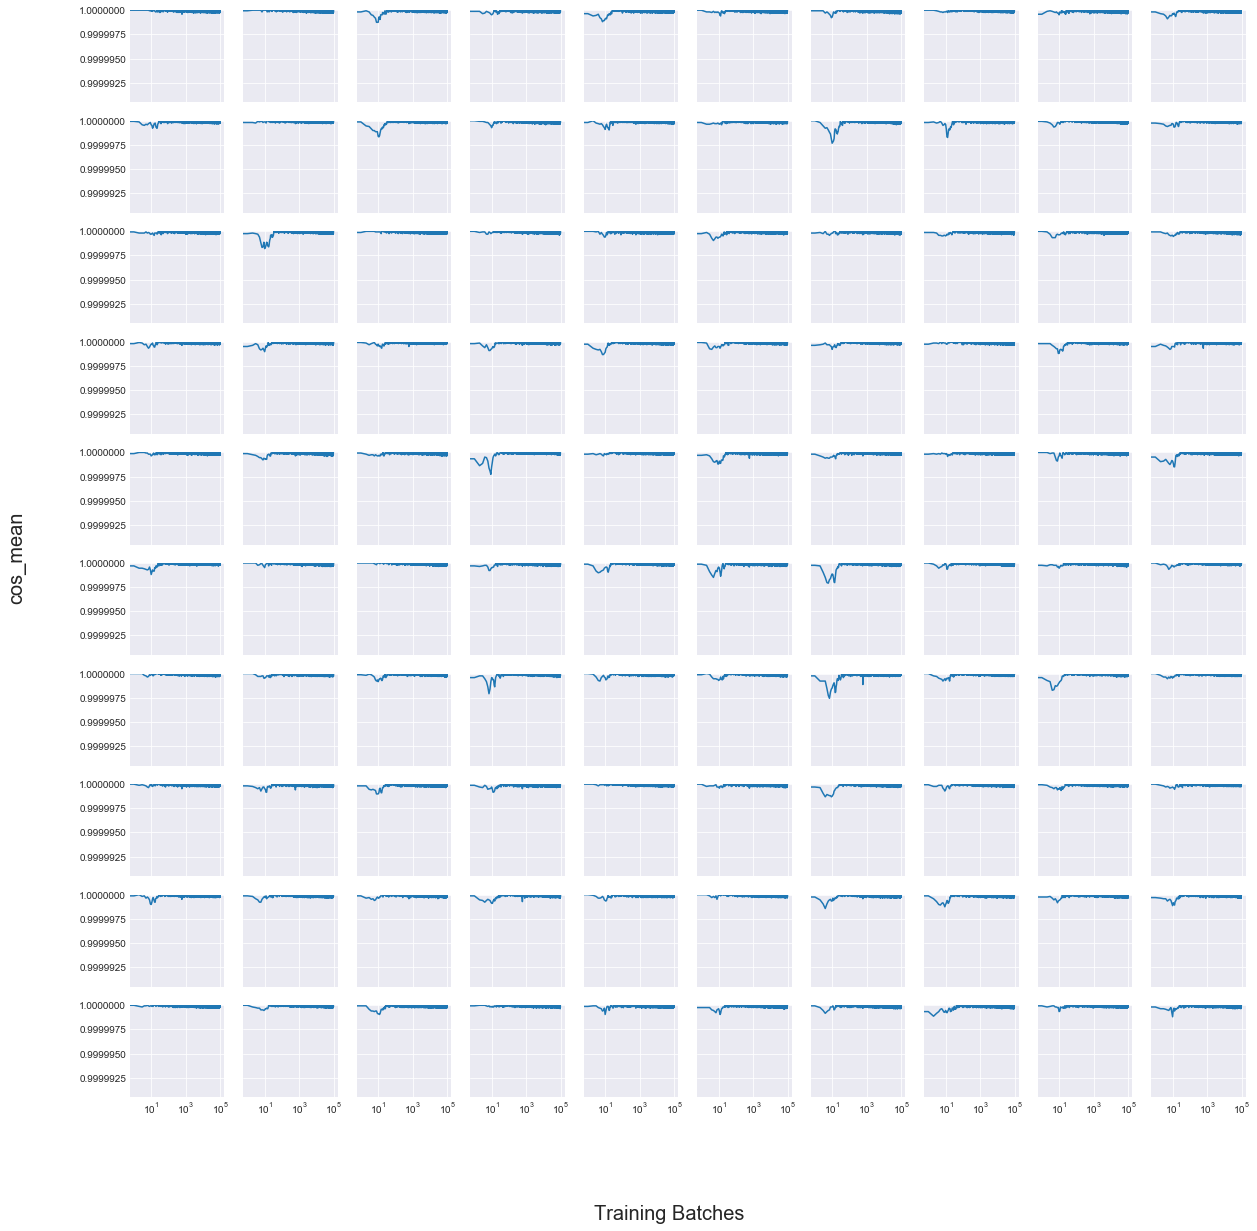

In [5]:
fig, ax = plt.subplots(10,10, figsize=(20,20))
i=0
for row in ax:
    for col in row:
        col.semilogx(cm_ranked[:,i])
        col.set_ylim(cm_ranked[:,100:].min(), 1)
        col.get_yaxis().get_major_formatter().set_useOffset(False)
        if i%10 != 0:
            col.set_yticklabels([])
        if i<90:
            col.set_xticklabels([])
        i += 1
fig.text(0.5, 0.04, 'Training Batches', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'cos_mean', va='center', rotation='vertical', fontsize=20)

Text(0.04, 0.5, 'sin_mean')

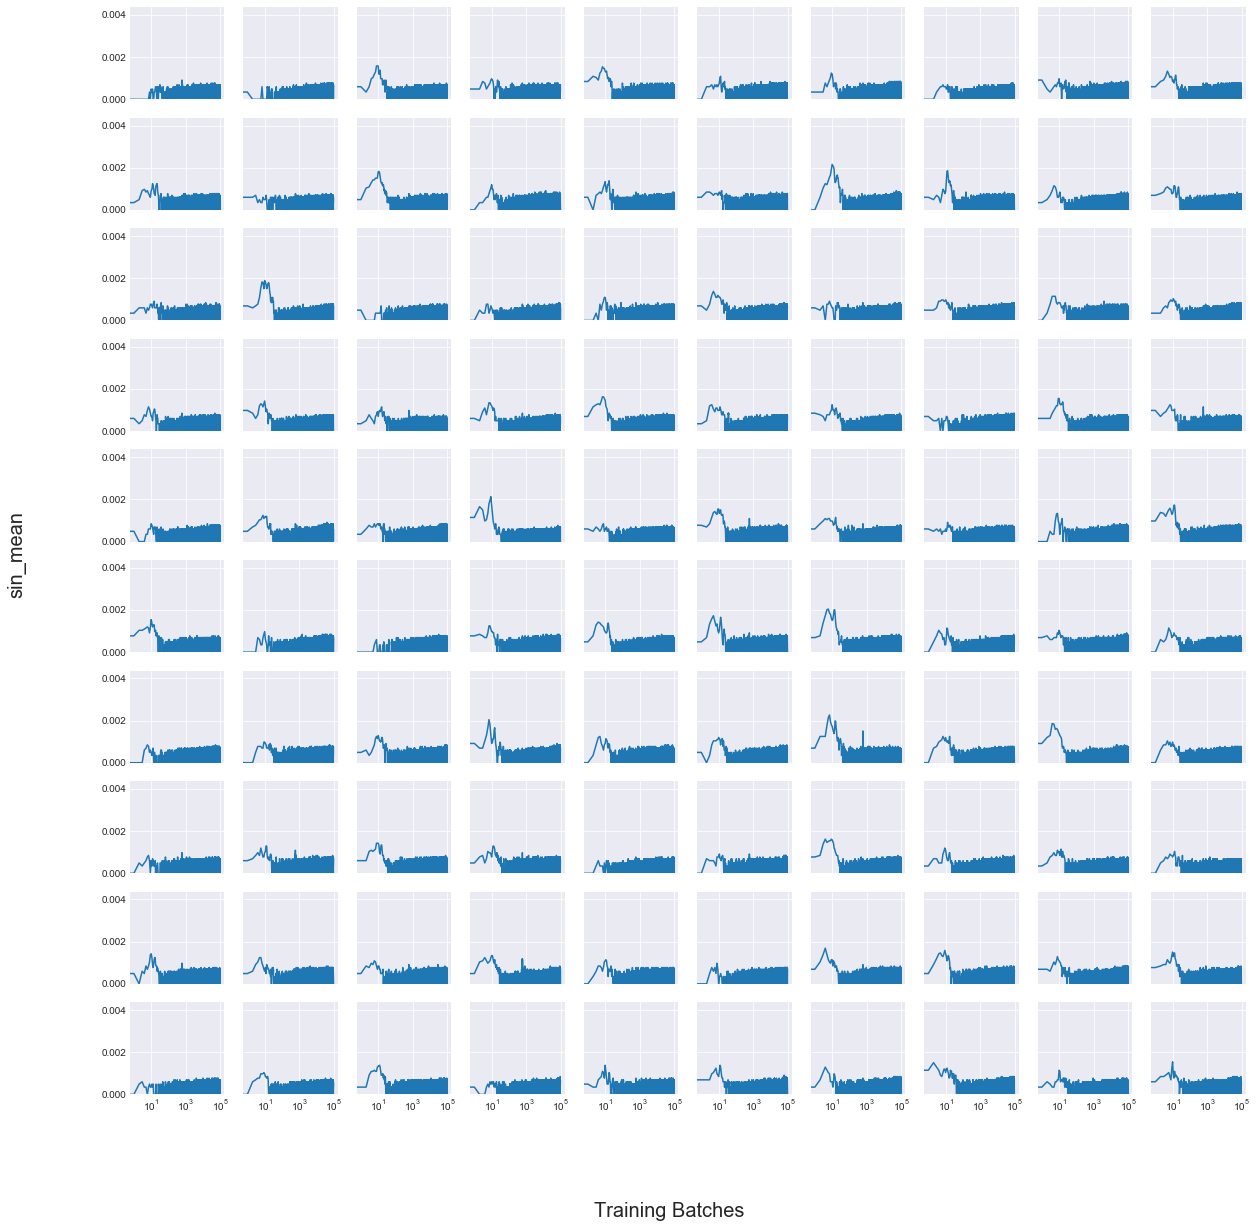

In [6]:
fig, ax = plt.subplots(10,10, figsize=(20,20))
i=0
for row in ax:
    for col in row:
        col.semilogx(sm_ranked[:,i])
        col.set_ylim(0, sm_ranked[:,100:].max())
        col.get_yaxis().get_major_formatter().set_useOffset(False)
        if i%10 != 0:
            col.set_yticklabels([])
        if i<90:
            col.set_xticklabels([])
        i += 1
fig.text(0.5, 0.04, 'Training Batches', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'sin_mean', va='center', rotation='vertical', fontsize=20)

# 38 (low overlap)

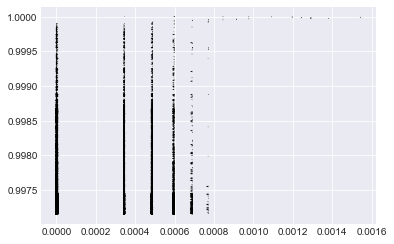

In [7]:
plt.quiver(sm_ranked[:-1,38], sd_ranked[:-2,38], sm_flow[:,38], sd_flow[:-1,38])

Text(0, 0.5, 'Pairwise sine')

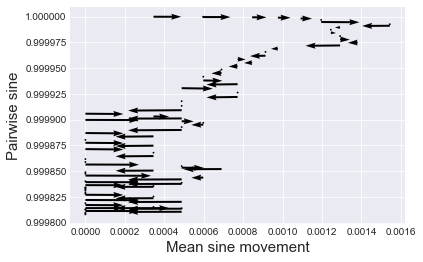

In [8]:
plt.quiver(sm_ranked[:100,38], sd_ranked[:100,38], sm_flow[:100,38], sd_flow[:100,38])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

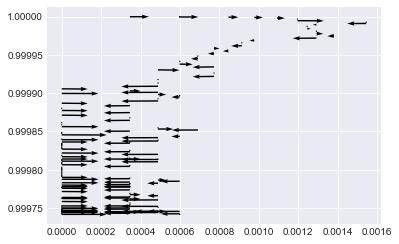

In [9]:
plt.quiver(sm_ranked[:200,38], sd_ranked[:200,38], sm_flow[:200,38], sd_flow[:200,38])

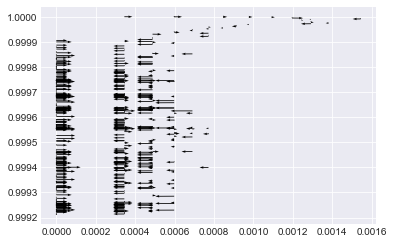

In [10]:
plt.quiver(sm_ranked[:1000,38], sd_ranked[:1000,38], sm_flow[:1000,38], sd_flow[:1000,38])

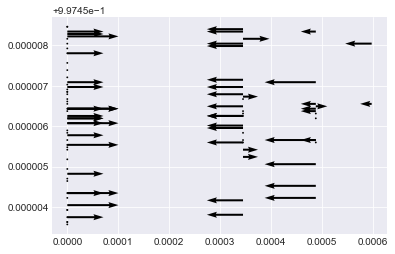

In [11]:
plt.quiver(sm_ranked[-101:-1,38], sd_ranked[-102:-2,38], sm_flow[-100:,38], sd_flow[-101:-1,38])

# 107

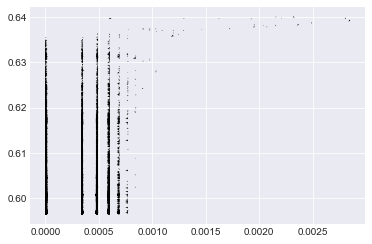

In [12]:
plt.quiver(sm_ranked[:-1,107], sd_ranked[:-2,107], sm_flow[:,107], sd_flow[:-1,107])

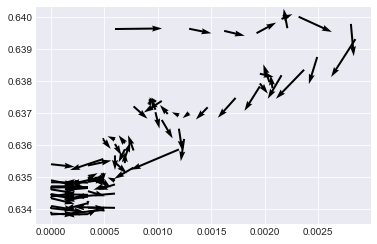

In [13]:
plt.quiver(sm_ranked[:100,107], sd_ranked[:100,107], sm_flow[:100,107], sd_flow[:100,107])

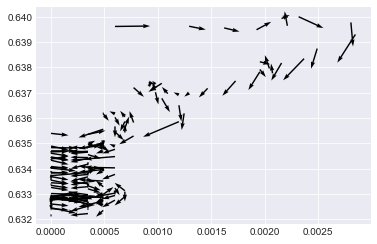

In [14]:
plt.quiver(sm_ranked[:200,107], sd_ranked[:200,107], sm_flow[:200,107], sd_flow[:200,107])

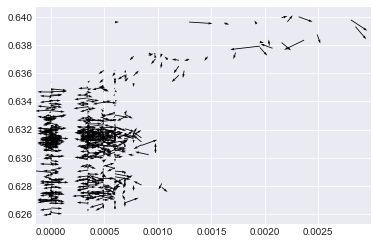

In [15]:
plt.quiver(sm_ranked[:1000,107], sd_ranked[:1000,107], sm_flow[:1000,147], sd_flow[:1000,107])

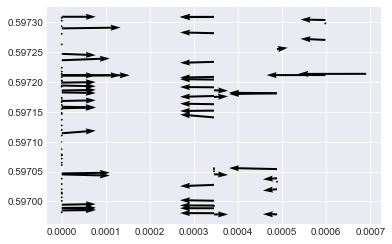

In [16]:
plt.quiver(sm_ranked[-101:-1,107], sd_ranked[-102:-2,107], sm_flow[-100:,107], sd_flow[-101:-1,107])

# 147

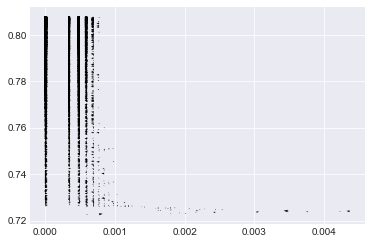

In [17]:
plt.quiver(sm_ranked[:-1,147], sd_ranked[:-2,147], sm_flow[:,147], sd_flow[:-1,147])

Text(0, 0.5, 'Pairwise sine')

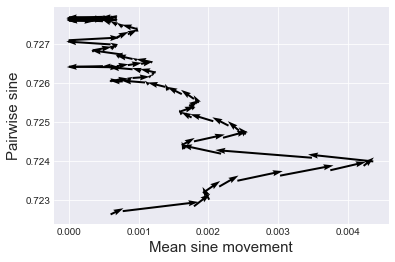

In [18]:
plt.quiver(sm_ranked[:100,147], sd_ranked[:100,147], sm_flow[:100,147], sd_flow[:100,147])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

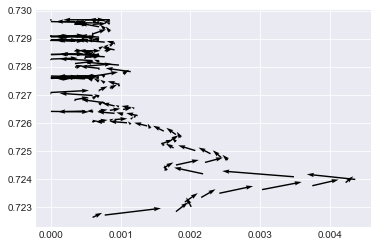

In [19]:
plt.quiver(sm_ranked[:200,147], sd_ranked[:200,147], sm_flow[:200,147], sd_flow[:200,147])

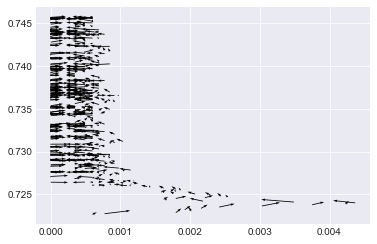

In [20]:
plt.quiver(sm_ranked[:1000,147], sd_ranked[:1000,147], sm_flow[:1000,147], sd_flow[:1000,147])

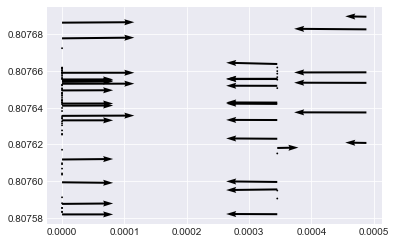

In [21]:
plt.quiver(sm_ranked[-101:-1,147], sd_ranked[-102:-2,147], sm_flow[-100:,147], sd_flow[-101:-1,147])

# 89

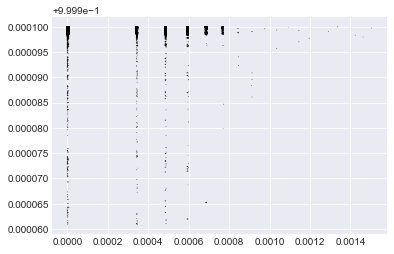

In [22]:
plt.quiver(sm_ranked[:-1,89], sd_ranked[:-2,89], sm_flow[:,89], sd_flow[:-1,89])

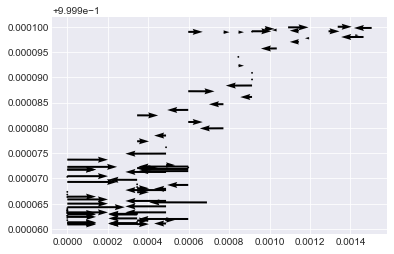

In [23]:
plt.quiver(sm_ranked[:100,89], sd_ranked[:100,89], sm_flow[:100,89], sd_flow[:100,89])

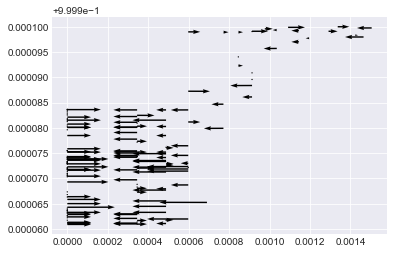

In [24]:
plt.quiver(sm_ranked[:200,89], sd_ranked[:200,89], sm_flow[:200,89], sd_flow[:200,89])

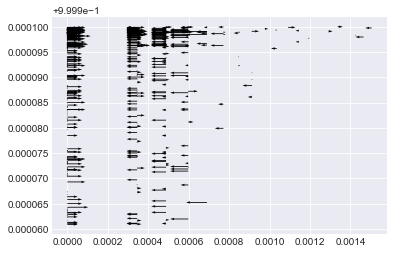

In [25]:
plt.quiver(sm_ranked[:1000,89], sd_ranked[:1000,89], sm_flow[:1000,89], sd_flow[:1000,89])

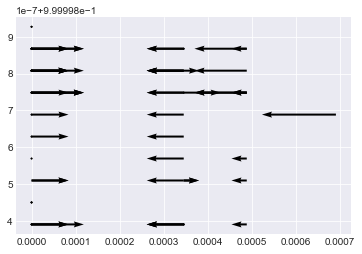

In [26]:
plt.quiver(sm_ranked[-101:-1,89], sd_ranked[-102:-2,89], sm_flow[-100:,89], sd_flow[-101:-1,89])

## Long-horizon dynamics

In [4]:
from metrics.metrics import CosineStats

In [10]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0

w = torch.load(os.path.join(parent_dir, 'weight_history/run_' + str(run_num),'epoch_1.pt'))
cosine_stats = CosineStats(w.dense_2, 100)

cd_long = []
cm_long = []

_, cd = cosine_stats.initial_stats()
cd_long.append(cd)

In [11]:
time_points = [1, 2, 10, 100, 200, 300, 400, 500, 600, 700, 800]

for t in time_points:
    w_next = torch.load(os.path.join(parent_dir, 'weight_history/run_' + str(run_num),'epoch_' + str(t) + '.pt'))
    w.dense_2.weight.data = w_next.dense_2.weight.data
    w.dense_2.bias.data = w_next.dense_2.bias.data
    _, cd, cm = cosine_stats.compute_stats()
    cd_long.append(cd)
    cm_long.append(cm)

In [12]:
cd_long = np.clip(np.array(cd_long), -1, 1)
cm_long = np.clip(np.array(cm_long), -1, 1)
sd_long = np.sqrt(1-cd_long**2)
sm_long = np.sqrt(1-cm_long**2)
loss_curve = np.load(os.path.join(parent_dir, 'loss_curve_' + str(run_num) + '.npy'))

cd_flow_long = cd_long[1:] - cd_long[:-1]
cm_flow_long = cm_long[1:] - cm_long[:-1]

sd_flow_long = sd_long[1:] - sd_long[:-1]
sm_flow_long = sm_long[1:] - sm_long[:-1]

Text(0, 0.5, 'Pairwise sine')

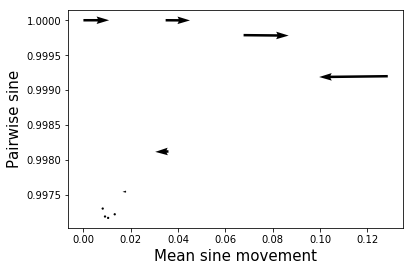

In [13]:
plt.quiver(sm_long[:-1,38], sd_long[:-2,38], sm_flow_long[:,38], sd_flow_long[:-1,38])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

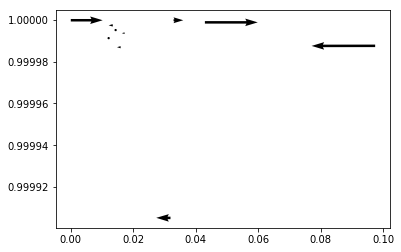

In [77]:
plt.quiver(sm_long[:-1,28], sd_long[:-2,28], sm_flow_long[:,28], sd_flow_long[:-1,28])

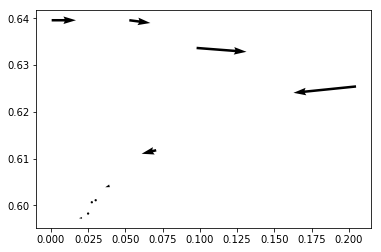

In [59]:
plt.quiver(sm_long[:-1,107], sd_long[:-2,107], sm_flow_long[:,107], sd_flow_long[:-1,107])

Text(0, 0.5, 'Pairwise sine')

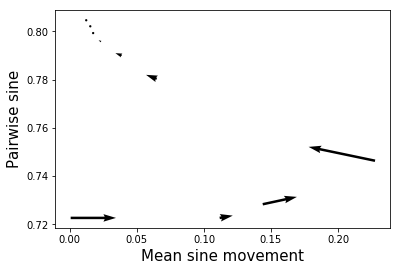

In [14]:
plt.quiver(sm_long[:-1,147], sd_long[:-2,147], sm_flow_long[:,147], sd_flow_long[:-1,147])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

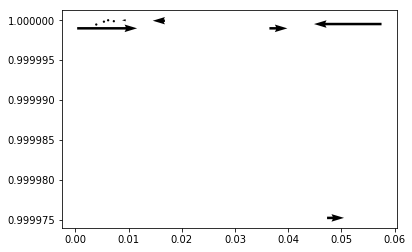

In [78]:
plt.quiver(sm_long[:-1,89], sd_long[:-2,89], sm_flow_long[:,89], sd_flow_long[:-1,89])

## Alternate measure for mean weight vector movement

In [27]:
from metrics.metrics import CosineStats

In [28]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/experiment_4/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 0

w = torch.load(os.path.join(parent_dir, 'weight_history/run_' + str(run_num),'epoch_1.pt'))
w_ref = torch.load(os.path.join(parent_dir, 'weight_history/run_' + str(run_num),'epoch_800.pt'))
cosine_stats = CosineStats(w.dense_2, 100, reference_layer=w_ref.dense_2)

cd_long = []
cm_long = []

_, cd, cm = cosine_stats.initial_stats()
cd_long.append(cd)
cm_long.append(cm)

In [29]:
time_points = [1, 2, 10, 100, 200, 300, 400, 500, 600, 700, 800]

for t in time_points:
    w_next = torch.load(os.path.join(parent_dir, 'weight_history/run_' + str(run_num),'epoch_' + str(t) + '.pt'))
    w.dense_2.weight.data = w_next.dense_2.weight.data
    w.dense_2.bias.data = w_next.dense_2.bias.data
    _, cd, cm = cosine_stats.compute_stats()
    cd_long.append(cd)
    cm_long.append(cm)

In [30]:
cd_long = np.clip(np.array(cd_long), -1, 1)
cm_long = np.clip(np.array(cm_long), -1, 1)
sd_long = np.sqrt(1-cd_long**2)
sm_long = np.sqrt(1-cm_long**2)
loss_curve = np.load(os.path.join(parent_dir, 'loss_curve_' + str(run_num) + '.npy'))

cd_flow_long = cd_long[1:] - cd_long[:-1]
cm_flow_long = cm_long[1:] - cm_long[:-1]

sd_flow_long = sd_long[1:] - sd_long[:-1]
sm_flow_long = sm_long[1:] - sm_long[:-1]

Text(0, 0.5, 'Pairwise sine')

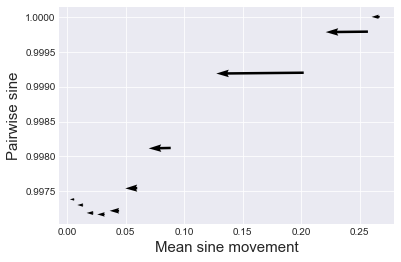

In [31]:
plt.quiver(sm_long[:-1,38], sd_long[:-1,38], sm_flow_long[:,38], sd_flow_long[:,38])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

Text(0, 0.5, 'Pairwise sine')

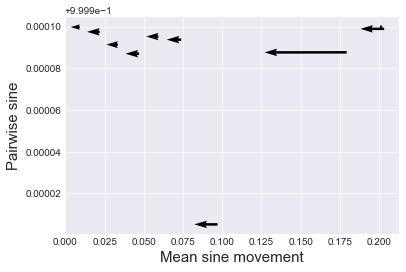

In [32]:
plt.quiver(sm_long[:-1,28], sd_long[:-1,28], sm_flow_long[:,28], sd_flow_long[:,28])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

Text(0, 0.5, 'Pairwise sine')

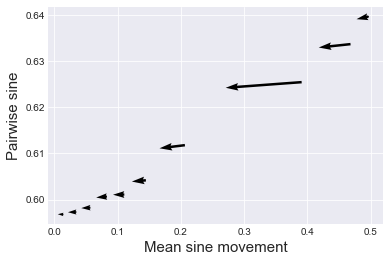

In [33]:
plt.quiver(sm_long[:-1,107], sd_long[:-1,107], sm_flow_long[:,107], sd_flow_long[:,107])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

Text(0, 0.5, 'Pairwise sine')

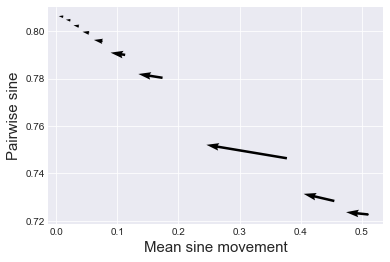

In [34]:
plt.quiver(sm_long[:-1,147], sd_long[:-1,147], sm_flow_long[:,147], sd_flow_long[:,147])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)

Text(0, 0.5, 'Pairwise sine')

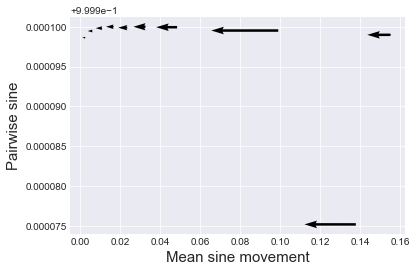

In [35]:
plt.quiver(sm_long[:-1,89], sd_long[:-1,89], sm_flow_long[:,89], sd_flow_long[:,89])
plt.xlabel('Mean sine movement', fontsize=15)
plt.ylabel('Pairwise sine', fontsize=15)